In [29]:
#import libraries
import datetime
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [30]:
#load data
cleaned = pd.read_csv('clean_train.csv', index_col=0)
cleaned_test = pd.read_csv('clean_test.csv', index_col=0)

X_ = cleaned.drop(['OutcomeType','OutcomeSubtype','AnimalID'], axis=1)
y_ = cleaned[['OutcomeType']]

X_TEST = cleaned_test.drop('ID', axis=1)
X_TEST_ids = cleaned_test['ID']

In [31]:
#sanity check -- ensure that train and test datasets have the same features
list(X_.columns) == list(X_TEST.columns)

True

In [32]:
#TRAIN
#scale age
scaler = StandardScaler()
age = scaler.fit_transform(X_['Age'].values.reshape(-1,1))
age = pd.DataFrame(age.reshape(-1))
age.columns = ['age_scaled']

#replace 'Age' with 'age_scaled'
X = pd.concat([X_, age], axis=1) #add scaled age
X = X.drop('Age', axis=1) #drop unscaled age

In [33]:
#TEST
#scale age for TEST
scaler = StandardScaler()
test_age = scaler.fit_transform(X_TEST['Age'].values.reshape(-1,1))
test_age = pd.DataFrame(test_age.reshape(-1))
test_age.columns = ['age_scaled']

#replace 'Age' with 'age_scaled' for TEST
X_test = pd.concat([X_TEST, test_age], axis=1) #add scaled age
X_test = X_test.drop('Age', axis=1) #drop unscaled age

In [34]:
#X = X.replace(0, -1) #replace binary dummy variables with -1 to match the scaling of age
#X = X.replace(0, -1) #replace binary dummy variables with -1 to match the scaling of age

#format as float numpy arrays
X = np.asarray(X, dtype='float')
X_TEST = np.asarray(X_TEST, dtype='float')

In [35]:
#encode target labels
encodr = LabelEncoder()
y = encodr.fit_transform(y_)

C:\Users\Will\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
#cross-validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

### Initial Test

In [37]:
# prepare models
models = []
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
models.append(('XGBoost', XGBClassifier()))

In [38]:
#prepare archives for saving results
results = []
names = []
preds = []
scoring = 'neg_log_loss'

------------------------------
K-Fold Cross-Validation: neg_log_loss
------------------------------
RandomForestClassifier: 3.949382 (0.226666)
AdaBoostClassifier: 1.553059 (0.001944)
GradientBoostingClassifier: 0.885903 (0.027905)
XGBoost: 0.879822 (0.020912)


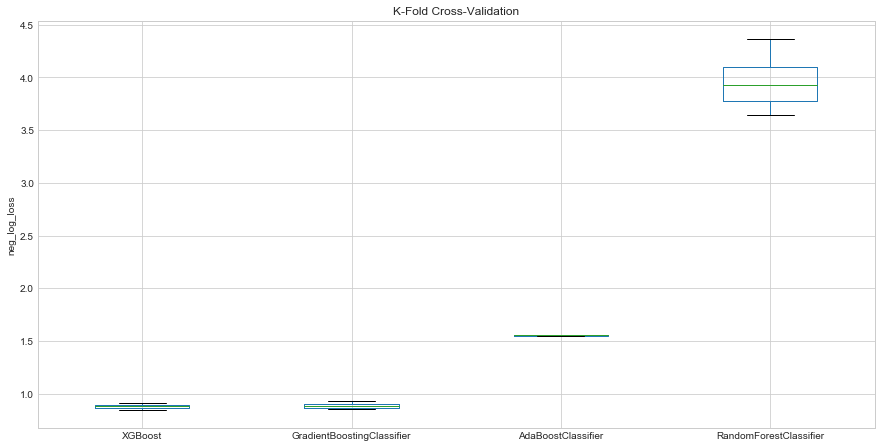

In [39]:
print('-'*30)
print('K-Fold Cross-Validation: {}'.format(scoring))
print('-'*30)

#Test the performance of each model against the data, using k-fold cross-validation
for name, model in models:

    kfold = model_selection.KFold(n_splits=10, random_state=7) #prepare K-fold CV
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring) #cross-validate model using K-fold CV
    cv_results = [abs(result) for result in cv_results] 
    cv_results = pd.Series(cv_results)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
#plot results
df = pd.DataFrame(results, names).T
summary = df.mean(axis=0).sort_values(ascending=True)
order = list(summary.index)
df = df[order]

viz = df.plot(kind='box',
              title='K-Fold Cross-Validation',
              figsize=(15,7.5))
viz.set_ylabel('{}'.format(scoring))

#f = viz.get_figure()
#plt.savefig('CV_results.png')

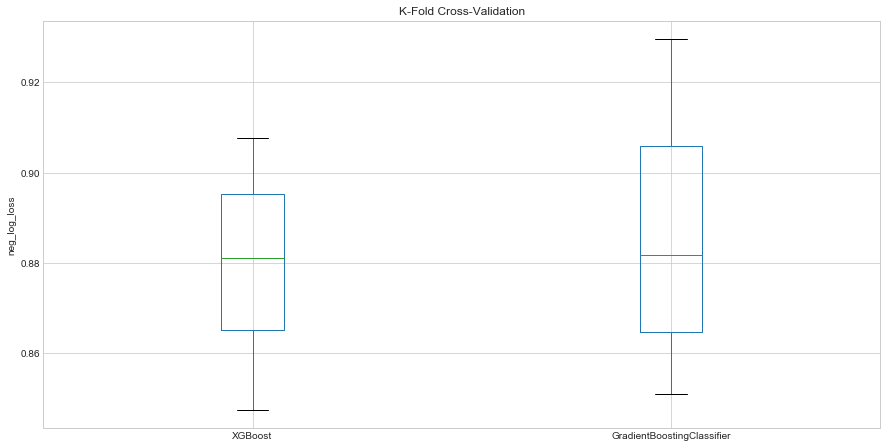

In [43]:
viz1 = df[['XGBoost','GradientBoostingClassifier']].plot(kind='box',
                                                       title='K-Fold Cross-Validation',
                                                       figsize=(15,7.5))
viz1.set_ylabel('{}'.format(scoring))